In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --- 1. Трансформации ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 2. Загрузка food11/train и food11/test ---
train_dataset = datasets.ImageFolder("./food11/train", transform=train_transform)
test_dataset = datasets.ImageFolder("./food11/test", transform=test_transform)

loader_args = dict(batch_size=64,
                   num_workers=0,
                   pin_memory=torch.cuda.is_available())

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)

# --- 3. EfficientNet-B0 ---
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super().__init__()
        weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
        self.base = efficientnet_b0(weights=weights)
        in_features = self.base.classifier[1].in_features
        self.base.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base(x)

# --- 4. Обучение и визуализация ---
def train_model(train_loader, test_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    model = EfficientNetB0(num_classes=11).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        correct, test_loss = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
        test_losses.append(test_loss / len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        print(f"Epoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, "
              f"TestLoss={test_losses[-1]:.4f}, Acc={test_accs[-1]:.2f}%")

    # --- Графики ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(test_accs)
    plt.title("Test Accuracy")

    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.show()

# --- 5. Запуск ---
train_model(train_loader, test_loader, epochs=10)


Epoch 1/10: 100%|██████████| 155/155 [14:34<00:00,  5.64s/it]


Epoch 1: TrainLoss=0.7805, TestLoss=0.5166, Acc=84.00%


Epoch 2/10: 100%|██████████| 155/155 [14:03<00:00,  5.44s/it]


Epoch 2: TrainLoss=0.4335, TestLoss=0.3809, Acc=88.27%


Epoch 3/10:   0%|          | 0/155 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [7]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# --- Параметры ---
data_dir = "./food11"
num_classes = 11
batch_size = 64
epochs = 3
lr = 0.001
weight_decay = 1e-4


In [8]:
# --- Аугментации ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [10]:
# --- Загрузка food11/train и food11/test ---
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

loader_args = dict(batch_size=batch_size,
                   num_workers=0,
                   pin_memory=torch.cuda.is_available())

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)


In [11]:
# --- EfficientNet-B0 ---
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super().__init__()
        weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
        self.base = efficientnet_b0(weights=weights)
        in_features = self.base.classifier[1].in_features
        self.base.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base(x)


Epoch 1/3: 100%|██████████| 155/155 [16:04<00:00,  6.22s/it]



Epoch 1: TrainLoss=0.7797, TestLoss=0.4773, Acc=85.73%

📊 Accuracy per class:
Class 0: 82.00% (82/100)
Class 1: 87.00% (87/100)
Class 2: 81.00% (81/100)
Class 3: 93.00% (93/100)
Class 4: 94.00% (94/100)
Class 5: 87.00% (87/100)
Class 6: 85.00% (85/100)
Class 7: 85.00% (85/100)
Class 8: 78.00% (78/100)
Class 9: 94.00% (94/100)
Class 10: 77.00% (77/100)


Epoch 2/3: 100%|██████████| 155/155 [17:03<00:00,  6.60s/it]



Epoch 2: TrainLoss=0.4299, TestLoss=0.4626, Acc=86.55%

📊 Accuracy per class:
Class 0: 73.00% (73/100)
Class 1: 87.00% (87/100)
Class 2: 87.00% (87/100)
Class 3: 93.00% (93/100)
Class 4: 87.00% (87/100)
Class 5: 92.00% (92/100)
Class 6: 82.00% (82/100)
Class 7: 91.00% (91/100)
Class 8: 80.00% (80/100)
Class 9: 95.00% (95/100)
Class 10: 85.00% (85/100)


Epoch 3/3: 100%|██████████| 155/155 [15:54<00:00,  6.16s/it]



Epoch 3: TrainLoss=0.3275, TestLoss=0.4704, Acc=85.27%

📊 Accuracy per class:
Class 0: 79.00% (79/100)
Class 1: 78.00% (78/100)
Class 2: 91.00% (91/100)
Class 3: 93.00% (93/100)
Class 4: 86.00% (86/100)
Class 5: 93.00% (93/100)
Class 6: 77.00% (77/100)
Class 7: 85.00% (85/100)
Class 8: 79.00% (79/100)
Class 9: 86.00% (86/100)
Class 10: 91.00% (91/100)


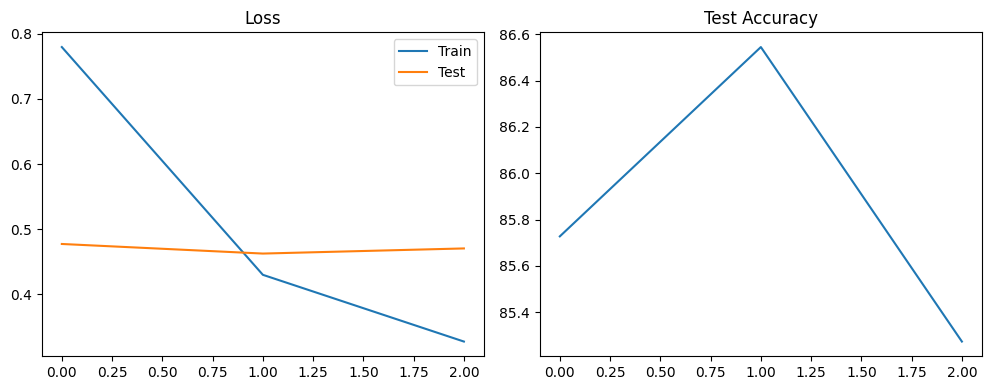

In [12]:
# --- Обучение ---
def train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    model = EfficientNetB0(num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        correct, test_loss = 0, 0
        class_correct = np.zeros(num_classes, dtype=int)
        class_total = np.zeros(num_classes, dtype=int)

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

                for i in range(len(target)):
                    label = target[i].item()
                    class_total[label] += 1
                    if pred[i].item() == label:
                        class_correct[label] += 1

        test_losses.append(test_loss / len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        print(f"\nEpoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, "
              f"TestLoss={test_losses[-1]:.4f}, Acc={test_accs[-1]:.2f}%")

        print("\n📊 Accuracy per class:")
        for i in range(num_classes):
            acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
            print(f"Class {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

    # --- Графики ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(test_accs)
    plt.title("Test Accuracy")

    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.show()

train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay)


Пробую добавить аугментацию по отстающим классам

In [ ]:


# --- Импорты ---
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# --- Параметры ---
data_dir = "./food11"
num_classes = 11
batch_size = 64
epochs = 10
lr = 0.001
weight_decay = 1e-4
weak_classes = {0, 1, 6, 8}  # можно обновлять после анализа

# --- Стандартная аугментация ---
default_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Усиленная аугментация ---
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Тестовая трансформация ---
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
class TargetedAugmentDataset(Dataset):
    def __init__(self, root, weak_classes, transform_default, transform_strong):
        self.dataset = datasets.ImageFolder(root)
        self.weak_classes = weak_classes
        self.transform_default = transform_default
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        path, label = self.dataset.samples[index]
        img = self.dataset.loader(path).convert("RGB")
        transform = self.transform_strong if label in self.weak_classes else self.transform_default
        return transform(img), label

    def __len__(self):
        return len(self.dataset)
train_dataset = TargetedAugmentDataset(
    os.path.join(data_dir, "train"),
    weak_classes,
    default_transform,
    strong_transform
)

test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

loader_args = dict(batch_size=batch_size,
                   num_workers=0,
                   pin_memory=torch.cuda.is_available())

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)




In [14]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super().__init__()
        weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
        self.base = efficientnet_b0(weights=weights)
        in_features = self.base.classifier[1].in_features
        self.base.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base(x)


In [ ]:
def train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    model = EfficientNetB0(num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    profiler = profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler("./logdir"),
        record_shapes=True,
        with_stack=True
    )
    profiler.start()

    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            with record_function("model_training"):
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            profiler.step()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        correct, test_loss = 0, 0
        class_correct = np.zeros(num_classes, dtype=int)
        class_total = np.zeros(num_classes, dtype=int)

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                for i in range(len(target)):
                    label = target[i].item()
                    class_total[label] += 1
                    if pred[i].item() == label:
                        class_correct[label] += 1

        test_losses.append(test_loss / len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        print(f"\nEpoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, "
              f"TestLoss={test_losses[-1]:.4f}, Acc={test_accs[-1]:.2f}%")

        print("\n📊 Accuracy per class:")
        per_class_acc = []
        for i in range(num_classes):
            acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
            per_class_acc.append(acc)
            print(f"Class {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

    profiler.stop()

    # --- Графики ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(test_accs)
    plt.title("Test Accuracy")

    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.show()


Epoch 1/10: 100%|██████████| 155/155 [15:31<00:00,  6.01s/it]



Epoch 1: TrainLoss=0.7909, TestLoss=0.6936, Acc=77.55%

📊 Accuracy per class:
Class 0: 46.00% (46/100)
Class 1: 78.00% (78/100)
Class 2: 86.00% (86/100)
Class 3: 92.00% (92/100)
Class 4: 87.00% (87/100)
Class 5: 85.00% (85/100)
Class 6: 46.00% (46/100)
Class 7: 93.00% (93/100)
Class 8: 66.00% (66/100)
Class 9: 89.00% (89/100)
Class 10: 85.00% (85/100)


Epoch 2/10: 100%|██████████| 155/155 [13:47<00:00,  5.34s/it]



Epoch 2: TrainLoss=0.4453, TestLoss=0.5011, Acc=83.27%

📊 Accuracy per class:
Class 0: 60.00% (60/100)
Class 1: 85.00% (85/100)
Class 2: 83.00% (83/100)
Class 3: 93.00% (93/100)
Class 4: 95.00% (95/100)
Class 5: 86.00% (86/100)
Class 6: 81.00% (81/100)
Class 7: 75.00% (75/100)
Class 8: 87.00% (87/100)
Class 9: 96.00% (96/100)
Class 10: 75.00% (75/100)


Epoch 3/10: 100%|██████████| 155/155 [13:45<00:00,  5.32s/it]



Epoch 3: TrainLoss=0.3646, TestLoss=0.6178, Acc=81.18%

📊 Accuracy per class:
Class 0: 54.00% (54/100)
Class 1: 71.00% (71/100)
Class 2: 83.00% (83/100)
Class 3: 92.00% (92/100)
Class 4: 97.00% (97/100)
Class 5: 80.00% (80/100)
Class 6: 87.00% (87/100)
Class 7: 93.00% (93/100)
Class 8: 52.00% (52/100)
Class 9: 94.00% (94/100)
Class 10: 90.00% (90/100)


Epoch 4/10: 100%|██████████| 155/155 [13:42<00:00,  5.30s/it]



Epoch 4: TrainLoss=0.2939, TestLoss=0.5193, Acc=84.45%

📊 Accuracy per class:
Class 0: 66.00% (66/100)
Class 1: 84.00% (84/100)
Class 2: 91.00% (91/100)
Class 3: 87.00% (87/100)
Class 4: 97.00% (97/100)
Class 5: 90.00% (90/100)
Class 6: 80.00% (80/100)
Class 7: 88.00% (88/100)
Class 8: 70.00% (70/100)
Class 9: 94.00% (94/100)
Class 10: 82.00% (82/100)


Epoch 5/10: 100%|██████████| 155/155 [13:17<00:00,  5.14s/it]



Epoch 5: TrainLoss=0.2598, TestLoss=0.4773, Acc=86.55%

📊 Accuracy per class:
Class 0: 68.00% (68/100)
Class 1: 84.00% (84/100)
Class 2: 83.00% (83/100)
Class 3: 92.00% (92/100)
Class 4: 92.00% (92/100)
Class 5: 97.00% (97/100)
Class 6: 74.00% (74/100)
Class 7: 93.00% (93/100)
Class 8: 84.00% (84/100)
Class 9: 96.00% (96/100)
Class 10: 89.00% (89/100)


Epoch 6/10: 100%|██████████| 155/155 [13:17<00:00,  5.15s/it]



Epoch 6: TrainLoss=0.2268, TestLoss=0.5449, Acc=83.91%

📊 Accuracy per class:
Class 0: 55.00% (55/100)
Class 1: 91.00% (91/100)
Class 2: 90.00% (90/100)
Class 3: 93.00% (93/100)
Class 4: 94.00% (94/100)
Class 5: 82.00% (82/100)
Class 6: 72.00% (72/100)
Class 7: 92.00% (92/100)
Class 8: 72.00% (72/100)
Class 9: 93.00% (93/100)
Class 10: 89.00% (89/100)


Epoch 7/10: 100%|██████████| 155/155 [13:16<00:00,  5.14s/it]



Epoch 7: TrainLoss=0.2167, TestLoss=0.4006, Acc=87.73%

📊 Accuracy per class:
Class 0: 80.00% (80/100)
Class 1: 86.00% (86/100)
Class 2: 90.00% (90/100)
Class 3: 93.00% (93/100)
Class 4: 93.00% (93/100)
Class 5: 86.00% (86/100)
Class 6: 87.00% (87/100)
Class 7: 85.00% (85/100)
Class 8: 84.00% (84/100)
Class 9: 93.00% (93/100)
Class 10: 88.00% (88/100)


Epoch 8/10: 100%|██████████| 155/155 [13:16<00:00,  5.14s/it]



Epoch 8: TrainLoss=0.1908, TestLoss=0.4704, Acc=85.55%

📊 Accuracy per class:
Class 0: 55.00% (55/100)
Class 1: 85.00% (85/100)
Class 2: 94.00% (94/100)
Class 3: 91.00% (91/100)
Class 4: 92.00% (92/100)
Class 5: 92.00% (92/100)
Class 6: 79.00% (79/100)
Class 7: 89.00% (89/100)
Class 8: 84.00% (84/100)
Class 9: 92.00% (92/100)
Class 10: 88.00% (88/100)


Epoch 9/10: 100%|██████████| 155/155 [13:22<00:00,  5.18s/it]



Epoch 9: TrainLoss=0.1762, TestLoss=0.5207, Acc=85.82%

📊 Accuracy per class:
Class 0: 72.00% (72/100)
Class 1: 82.00% (82/100)
Class 2: 95.00% (95/100)
Class 3: 94.00% (94/100)
Class 4: 86.00% (86/100)
Class 5: 84.00% (84/100)
Class 6: 78.00% (78/100)
Class 7: 88.00% (88/100)
Class 8: 82.00% (82/100)
Class 9: 95.00% (95/100)
Class 10: 88.00% (88/100)


Epoch 10/10: 100%|██████████| 155/155 [13:20<00:00,  5.17s/it]



Epoch 10: TrainLoss=0.1774, TestLoss=0.4193, Acc=87.73%

📊 Accuracy per class:
Class 0: 77.00% (77/100)
Class 1: 86.00% (86/100)
Class 2: 89.00% (89/100)
Class 3: 94.00% (94/100)
Class 4: 91.00% (91/100)
Class 5: 94.00% (94/100)
Class 6: 77.00% (77/100)
Class 7: 88.00% (88/100)
Class 8: 86.00% (86/100)
Class 9: 91.00% (91/100)
Class 10: 92.00% (92/100)


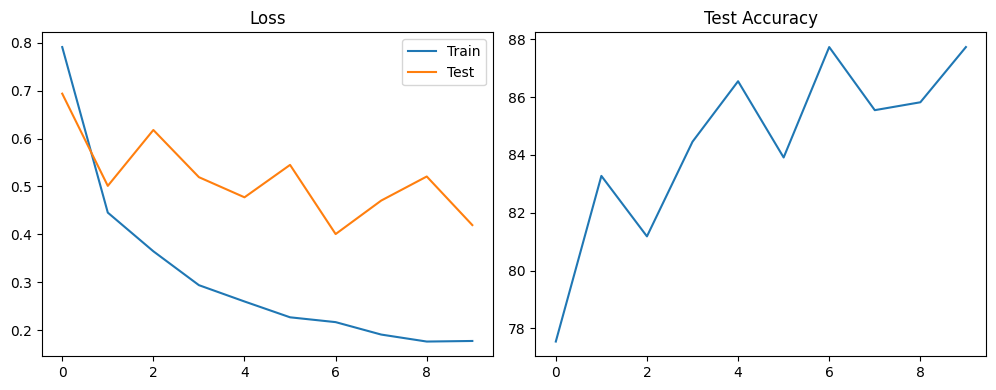

In [16]:
train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay)


tensorboard --logdir=./logdir


In [17]:


# --- Импорты ---
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from sklearn.metrics import classification_report

# --- Параметры ---
data_dir = "./food11"
num_classes = 11
batch_size = 64
epochs = 3
lr = 0.002
weight_decay = 1e-4
weak_classes = {0, 1, 6, 8}  # можно обновлять после анализа

# --- Стандартная аугментация ---
default_transform = transforms.Compose([
    transforms.RandomResizedCrop(240, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Усиленная аугментация ---
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(240, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Тестовая трансформация ---
test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class TargetedAugmentDataset(Dataset):
    def __init__(self, root, weak_classes, transform_default, transform_strong):
        self.dataset = datasets.ImageFolder(root)
        self.weak_classes = weak_classes
        self.transform_default = transform_default
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        path, label = self.dataset.samples[index]
        img = self.dataset.loader(path).convert("RGB")
        transform = self.transform_strong if label in self.weak_classes else self.transform_default
        return transform(img), label

    def __len__(self):
        return len(self.dataset)
train_dataset = TargetedAugmentDataset(
    os.path.join(data_dir, "train"),
    weak_classes,
    default_transform,
    strong_transform
)

test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

loader_args = dict(batch_size=batch_size,
                   num_workers=0,
                   pin_memory=torch.cuda.is_available())

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)




In [18]:
class EfficientNetB1(nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super().__init__()
        weights = EfficientNet_B1_Weights.DEFAULT if pretrained else None
        self.base = efficientnet_b1(weights=weights)
        in_features = self.base.classifier[1].in_features
        self.base.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base(x)


In [19]:
def train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    model = EfficientNetB1(num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    profiler = profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler("./logdir"),
        record_shapes=True,
        with_stack=True
    )
    profiler.start()

    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            with record_function("model_training"):
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            profiler.step()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        correct, test_loss = 0, 0
        class_correct = np.zeros(num_classes, dtype=int)
        class_total = np.zeros(num_classes, dtype=int)

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                for i in range(len(target)):
                    label = target[i].item()
                    class_total[label] += 1
                    if pred[i].item() == label:
                        class_correct[label] += 1

        test_losses.append(test_loss / len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        print(f"\nEpoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, "
              f"TestLoss={test_losses[-1]:.4f}, Acc={test_accs[-1]:.2f}%")

        print("\n📊 Accuracy per class:")
        per_class_acc = []
        for i in range(num_classes):
            acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
            per_class_acc.append(acc)
            print(f"Class {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

    profiler.stop()

    # --- Графики ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(test_accs)
    plt.title("Test Accuracy")

    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.show()



    # --- Собираем все предсказания и цели ---
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # --- Мультиклассовый отчёт ---
    print("\n📊 Multiclass classification report (F1, Precision, Recall):")
    report = classification_report(
        all_targets,
        all_preds,
        digits=3,
        zero_division=0
    )
    print(report)



Epoch 1/3: 100%|██████████| 155/155 [31:53<00:00, 12.35s/it]



Epoch 1: TrainLoss=0.7520, TestLoss=0.5934, Acc=80.64%

📊 Accuracy per class:
Class 0: 42.00% (42/100)
Class 1: 80.00% (80/100)
Class 2: 90.00% (90/100)
Class 3: 92.00% (92/100)
Class 4: 91.00% (91/100)
Class 5: 85.00% (85/100)
Class 6: 76.00% (76/100)
Class 7: 83.00% (83/100)
Class 8: 66.00% (66/100)
Class 9: 94.00% (94/100)
Class 10: 88.00% (88/100)


Epoch 2/3: 100%|██████████| 155/155 [30:46<00:00, 11.91s/it]



Epoch 2: TrainLoss=0.4282, TestLoss=0.4804, Acc=84.73%

📊 Accuracy per class:
Class 0: 61.00% (61/100)
Class 1: 82.00% (82/100)
Class 2: 90.00% (90/100)
Class 3: 89.00% (89/100)
Class 4: 91.00% (91/100)
Class 5: 79.00% (79/100)
Class 6: 80.00% (80/100)
Class 7: 94.00% (94/100)
Class 8: 84.00% (84/100)
Class 9: 95.00% (95/100)
Class 10: 87.00% (87/100)


Epoch 3/3: 100%|██████████| 155/155 [30:54<00:00, 11.96s/it]



Epoch 3: TrainLoss=0.3631, TestLoss=0.6503, Acc=81.55%

📊 Accuracy per class:
Class 0: 43.00% (43/100)
Class 1: 73.00% (73/100)
Class 2: 91.00% (91/100)
Class 3: 82.00% (82/100)
Class 4: 94.00% (94/100)
Class 5: 88.00% (88/100)
Class 6: 83.00% (83/100)
Class 7: 91.00% (91/100)
Class 8: 76.00% (76/100)
Class 9: 90.00% (90/100)
Class 10: 86.00% (86/100)


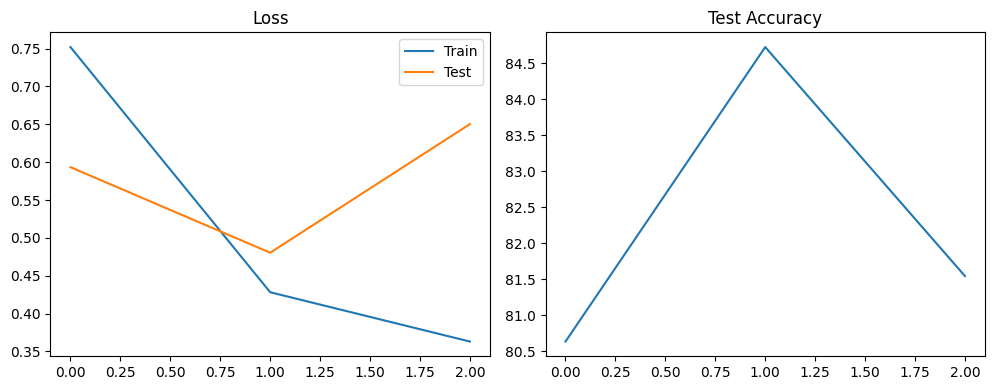


📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.956     0.430     0.593       100
           1      0.890     0.730     0.802       100
           2      0.684     0.910     0.781       100
           3      0.863     0.820     0.841       100
           4      0.817     0.940     0.874       100
           5      0.871     0.880     0.876       100
           6      0.806     0.830     0.818       100
           7      0.705     0.910     0.795       100
           8      0.817     0.760     0.788       100
           9      0.957     0.900     0.928       100
          10      0.782     0.860     0.819       100

    accuracy                          0.815      1100
   macro avg      0.832     0.815     0.810      1100
weighted avg      0.832     0.815     0.810      1100



In [20]:

train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay)


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support

# --- Параметры ---
data_dir = "./food11"
num_classes = 11
batch_size = 64
epochs = 10
lr = 0.001
weight_decay = 1e-4
f1_threshold = 0.80


In [22]:
# --- Стандартная аугментация ---
default_transform = transforms.Compose([
    transforms.RandomResizedCrop(240, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Усиленная аугментация ---
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(240, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Тестовая трансформация ---
test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [23]:
class TargetedAugmentDataset(Dataset):
    def __init__(self, root, weak_classes, transform_default, transform_strong):
        self.dataset = datasets.ImageFolder(root)
        self.weak_classes = weak_classes
        self.transform_default = transform_default
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        path, label = self.dataset.samples[index]
        img = self.dataset.loader(path).convert("RGB")
        transform = self.transform_strong if label in self.weak_classes else self.transform_default
        return transform(img), label

    def __len__(self):
        return len(self.dataset)


In [24]:
# Инициализация слабых классов вручную (можно обновлять после первой эпохи)
initial_weak_classes = {0, 1, 6, 8}

train_dataset = TargetedAugmentDataset(
    os.path.join(data_dir, "train"),
    initial_weak_classes,
    default_transform,
    strong_transform
)

test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

loader_args = dict(batch_size=batch_size,
                   num_workers=0,
                   pin_memory=torch.cuda.is_available())

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)


In [25]:
class EfficientNetB1(nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super().__init__()
        weights = EfficientNet_B1_Weights.DEFAULT if pretrained else None
        self.base = efficientnet_b1(weights=weights)
        in_features = self.base.classifier[1].in_features
        self.base.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base(x)


Epoch 1/10: 100%|██████████| 155/155 [28:51<00:00, 11.17s/it]



Epoch 1: TrainLoss=0.6863, TestLoss=0.5184, Acc=83.91%

📊 Accuracy per class:
Class 0: 70.00% (70/100)
Class 1: 70.00% (70/100)
Class 2: 89.00% (89/100)
Class 3: 92.00% (92/100)
Class 4: 95.00% (95/100)
Class 5: 90.00% (90/100)
Class 6: 84.00% (84/100)
Class 7: 87.00% (87/100)
Class 8: 60.00% (60/100)
Class 9: 95.00% (95/100)
Class 10: 91.00% (91/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.753     0.700     0.725       100
           1      0.959     0.700     0.809       100
           2      0.742     0.890     0.809       100
           3      0.968     0.920     0.944       100
           4      0.812     0.950     0.876       100
           5      0.891     0.900     0.896       100
           6      0.988     0.840     0.908       100
           7      0.713     0.870     0.784       100
           8      0.923     0.600     0.727       100
           9      0.841     0.950     0.892

Epoch 2/10: 100%|██████████| 155/155 [28:52<00:00, 11.18s/it]



Epoch 2: TrainLoss=0.3563, TestLoss=0.4572, Acc=85.00%

📊 Accuracy per class:
Class 0: 70.00% (70/100)
Class 1: 75.00% (75/100)
Class 2: 96.00% (96/100)
Class 3: 90.00% (90/100)
Class 4: 91.00% (91/100)
Class 5: 90.00% (90/100)
Class 6: 78.00% (78/100)
Class 7: 91.00% (91/100)
Class 8: 69.00% (69/100)
Class 9: 96.00% (96/100)
Class 10: 89.00% (89/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.843     0.700     0.765       100
           1      0.962     0.750     0.843       100
           2      0.727     0.960     0.828       100
           3      0.938     0.900     0.918       100
           4      0.910     0.910     0.910       100
           5      0.874     0.900     0.887       100
           6      0.963     0.780     0.862       100
           7      0.684     0.910     0.781       100
           8      0.958     0.690     0.802       100
           9      0.857     0.960     0.906

Epoch 3/10: 100%|██████████| 155/155 [33:29<00:00, 12.97s/it]



Epoch 3: TrainLoss=0.2556, TestLoss=0.3890, Acc=88.27%

📊 Accuracy per class:
Class 0: 80.00% (80/100)
Class 1: 86.00% (86/100)
Class 2: 92.00% (92/100)
Class 3: 91.00% (91/100)
Class 4: 96.00% (96/100)
Class 5: 91.00% (91/100)
Class 6: 86.00% (86/100)
Class 7: 89.00% (89/100)
Class 8: 78.00% (78/100)
Class 9: 94.00% (94/100)
Class 10: 88.00% (88/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.800     0.800     0.800       100
           1      0.915     0.860     0.887       100
           2      0.800     0.920     0.856       100
           3      0.919     0.910     0.915       100
           4      0.793     0.960     0.869       100
           5      0.919     0.910     0.915       100
           6      0.956     0.860     0.905       100
           7      0.817     0.890     0.852       100
           8      0.963     0.780     0.862       100
           9      0.959     0.940     0.949

Epoch 4/10: 100%|██████████| 155/155 [31:28<00:00, 12.18s/it]



Epoch 4: TrainLoss=0.2101, TestLoss=0.4070, Acc=87.00%

📊 Accuracy per class:
Class 0: 75.00% (75/100)
Class 1: 85.00% (85/100)
Class 2: 91.00% (91/100)
Class 3: 89.00% (89/100)
Class 4: 93.00% (93/100)
Class 5: 91.00% (91/100)
Class 6: 73.00% (73/100)
Class 7: 92.00% (92/100)
Class 8: 88.00% (88/100)
Class 9: 91.00% (91/100)
Class 10: 89.00% (89/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.815     0.750     0.781       100
           1      0.944     0.850     0.895       100
           2      0.771     0.910     0.835       100
           3      0.927     0.890     0.908       100
           4      0.912     0.930     0.921       100
           5      0.835     0.910     0.871       100
           6      0.973     0.730     0.834       100
           7      0.767     0.920     0.836       100
           8      0.871     0.880     0.876       100
           9      0.968     0.910     0.938

Epoch 5/10: 100%|██████████| 155/155 [32:29<00:00, 12.58s/it]



Epoch 5: TrainLoss=0.1725, TestLoss=0.4341, Acc=87.27%

📊 Accuracy per class:
Class 0: 61.00% (61/100)
Class 1: 83.00% (83/100)
Class 2: 97.00% (97/100)
Class 3: 92.00% (92/100)
Class 4: 88.00% (88/100)
Class 5: 95.00% (95/100)
Class 6: 84.00% (84/100)
Class 7: 89.00% (89/100)
Class 8: 87.00% (87/100)
Class 9: 97.00% (97/100)
Class 10: 87.00% (87/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.871     0.610     0.718       100
           1      0.943     0.830     0.883       100
           2      0.808     0.970     0.882       100
           3      0.968     0.920     0.944       100
           4      0.978     0.880     0.926       100
           5      0.812     0.950     0.876       100
           6      0.866     0.840     0.853       100
           7      0.795     0.890     0.840       100
           8      0.935     0.870     0.902       100
           9      0.795     0.970     0.874

Epoch 6/10: 100%|██████████| 155/155 [32:20<00:00, 12.52s/it]



Epoch 6: TrainLoss=0.1685, TestLoss=0.3474, Acc=88.91%

📊 Accuracy per class:
Class 0: 67.00% (67/100)
Class 1: 82.00% (82/100)
Class 2: 93.00% (93/100)
Class 3: 93.00% (93/100)
Class 4: 94.00% (94/100)
Class 5: 95.00% (95/100)
Class 6: 88.00% (88/100)
Class 7: 87.00% (87/100)
Class 8: 90.00% (90/100)
Class 9: 95.00% (95/100)
Class 10: 94.00% (94/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.859     0.670     0.753       100
           1      0.965     0.820     0.886       100
           2      0.869     0.930     0.899       100
           3      0.939     0.930     0.935       100
           4      0.913     0.940     0.926       100
           5      0.841     0.950     0.892       100
           6      0.946     0.880     0.912       100
           7      0.829     0.870     0.849       100
           8      0.938     0.900     0.918       100
           9      0.864     0.950     0.905

Epoch 7/10: 100%|██████████| 155/155 [32:22<00:00, 12.54s/it]



Epoch 7: TrainLoss=0.1298, TestLoss=0.3968, Acc=88.09%

📊 Accuracy per class:
Class 0: 83.00% (83/100)
Class 1: 77.00% (77/100)
Class 2: 87.00% (87/100)
Class 3: 88.00% (88/100)
Class 4: 94.00% (94/100)
Class 5: 94.00% (94/100)
Class 6: 84.00% (84/100)
Class 7: 91.00% (91/100)
Class 8: 82.00% (82/100)
Class 9: 97.00% (97/100)
Class 10: 92.00% (92/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.830     0.830     0.830       100
           1      0.939     0.770     0.846       100
           2      0.916     0.870     0.892       100
           3      0.967     0.880     0.921       100
           4      0.922     0.940     0.931       100
           5      0.855     0.940     0.895       100
           6      0.944     0.840     0.889       100
           7      0.684     0.910     0.781       100
           8      0.943     0.820     0.877       100
           9      0.915     0.970     0.942

Epoch 8/10: 100%|██████████| 155/155 [32:31<00:00, 12.59s/it]



Epoch 8: TrainLoss=0.1173, TestLoss=0.3456, Acc=90.55%

📊 Accuracy per class:
Class 0: 79.00% (79/100)
Class 1: 85.00% (85/100)
Class 2: 95.00% (95/100)
Class 3: 95.00% (95/100)
Class 4: 95.00% (95/100)
Class 5: 97.00% (97/100)
Class 6: 86.00% (86/100)
Class 7: 90.00% (90/100)
Class 8: 88.00% (88/100)
Class 9: 94.00% (94/100)
Class 10: 92.00% (92/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.832     0.790     0.810       100
           1      0.924     0.850     0.885       100
           2      0.896     0.950     0.922       100
           3      0.941     0.950     0.945       100
           4      0.931     0.950     0.941       100
           5      0.802     0.970     0.878       100
           6      0.956     0.860     0.905       100
           7      0.874     0.900     0.887       100
           8      0.967     0.880     0.921       100
           9      0.959     0.940     0.949

Epoch 9/10: 100%|██████████| 155/155 [32:33<00:00, 12.60s/it]



Epoch 9: TrainLoss=0.1141, TestLoss=0.3917, Acc=90.00%

📊 Accuracy per class:
Class 0: 82.00% (82/100)
Class 1: 87.00% (87/100)
Class 2: 93.00% (93/100)
Class 3: 92.00% (92/100)
Class 4: 96.00% (96/100)
Class 5: 90.00% (90/100)
Class 6: 87.00% (87/100)
Class 7: 87.00% (87/100)
Class 8: 87.00% (87/100)
Class 9: 97.00% (97/100)
Class 10: 92.00% (92/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.863     0.820     0.841       100
           1      0.935     0.870     0.902       100
           2      0.886     0.930     0.907       100
           3      0.939     0.920     0.929       100
           4      0.881     0.960     0.919       100
           5      0.874     0.900     0.887       100
           6      0.956     0.870     0.911       100
           7      0.845     0.870     0.857       100
           8      0.967     0.870     0.916       100
           9      0.907     0.970     0.937

Epoch 10/10: 100%|██████████| 155/155 [32:02<00:00, 12.40s/it]



Epoch 10: TrainLoss=0.1042, TestLoss=0.3896, Acc=89.64%

📊 Accuracy per class:
Class 0: 78.00% (78/100)
Class 1: 86.00% (86/100)
Class 2: 92.00% (92/100)
Class 3: 93.00% (93/100)
Class 4: 95.00% (95/100)
Class 5: 90.00% (90/100)
Class 6: 90.00% (90/100)
Class 7: 90.00% (90/100)
Class 8: 94.00% (94/100)
Class 9: 94.00% (94/100)
Class 10: 84.00% (84/100)

📊 Multiclass classification report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      0.886     0.780     0.830       100
           1      0.905     0.860     0.882       100
           2      0.929     0.920     0.925       100
           3      0.930     0.930     0.930       100
           4      0.856     0.950     0.900       100
           5      0.918     0.900     0.909       100
           6      0.928     0.900     0.914       100
           7      0.776     0.900     0.833       100
           8      0.862     0.940     0.900       100
           9      0.959     0.940     0.94

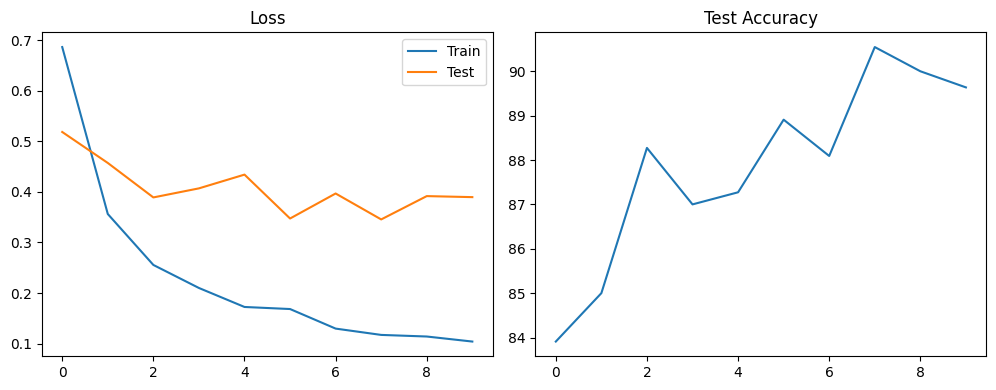

In [26]:
def train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    model = EfficientNetB1(num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    profiler = profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler("./logdir"),
        record_shapes=True,
        with_stack=True
    )
    profiler.start()

    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            with record_function("model_training"):
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            profiler.step()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        correct, test_loss = 0, 0
        class_correct = np.zeros(num_classes, dtype=int)
        class_total = np.zeros(num_classes, dtype=int)
        all_preds, all_targets = [], []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                for i in range(len(target)):
                    label = target[i].item()
                    class_total[label] += 1
                    if pred[i].item() == label:
                        class_correct[label] += 1

        test_losses.append(test_loss / len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        print(f"\nEpoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, "
              f"TestLoss={test_losses[-1]:.4f}, Acc={test_accs[-1]:.2f}%")

        print("\n📊 Accuracy per class:")
        for i in range(num_classes):
            acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
            print(f"Class {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

        print("\n📊 Multiclass classification report (F1, Precision, Recall):")
        report = classification_report(all_targets, all_preds, digits=3, zero_division=0)
        print(report)

        precision, recall, f1, support = precision_recall_fscore_support(
            all_targets, all_preds, labels=list(range(num_classes)), zero_division=0
        )
        weak_classes = {i for i, score in enumerate(f1) if score < f1_threshold}
        print("\n⚠️ Weak classes by F1-score < {:.2f}: {}".format(f1_threshold, sorted(weak_classes)))

        # --- Визуализация F1 ---
        plt.figure(figsize=(10, 4))
        plt.bar(range(num_classes), f1)
        plt.title(f"F1-score per class (Epoch {epoch+1})")
        plt.xlabel("Class")
        plt.ylabel("F1-score")
        plt.ylim(0, 1)
        plt.savefig(f"f1_epoch_{epoch+1}.png")
        plt.close()

    profiler.stop()

    # --- Графики потерь и точности ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(test_accs)
    plt.title("Test Accuracy")

    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.show()


train_model(train_loader, test_loader, num_classes, epochs, lr, weight_decay)
